<a href="https://colab.research.google.com/github/Katlnkld/GANs/blob/main/gan_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative adversarial networks


Задача: обучить GAN генерировать лица людей и посмотреть на то, как можно оценивать качество генерации

In [ ]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

## Часть 1. Подготовка данных

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://drive.google.com/file/d/1KWPc4Pa7u2TWekUvNu9rTSO0U2eOlZA9/view?usp=sharing)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения

Так как датасет слишком большой и грузится долго - приведем картинки к размеру 128*128 и будем далее работать с уже урезанным датасетом.

In [ ]:
!pip install -q -U --no-cache-dir gdown --pre
!gdown --id 1gOyqJ0_3oHVhBS2QqB4pSnV1VjfFfA-T
!tar -xzf faces_dataset_small_128.tgz && rm faces_dataset_small_128.tgz

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
Downloading...
From: https://drive.google.com/uc?id=1gOyqJ0_3oHVhBS2QqB4pSnV1VjfFfA-T
To: /content/faces_dataset_small_128.tgz
74.2MB [00:04, 17.7MB/s]


In [ ]:
DATA_DIR = '/content/faces_dataset_small_128/'

Напишем функцию, которая делает ресайз изображений, переводит в тензоры, нормализует и строит даталоадер.

In [ ]:
def get_dataloader(image_size, batch_size, stats):
    print(DATA_DIR)
    train_ds = ImageFolder(DATA_DIR, transform=tt.Compose([
        #tt.Resize(image_size),
        tt.CenterCrop(image_size),
        tt.ToTensor(),
        tt.Normalize(*stats)]))
    dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
    return(dl)

In [ ]:
image_size = 128 
batch_size = 16
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

#build dataloader and transfer it to device

train_dl = get_dataloader(image_size, batch_size, stats)

/content/faces_dataset_small_128/


Количество изображений в датасете:

In [ ]:
len(ImageFolder(DATA_DIR))

3143

Посмотрим на изображения в датасете

In [ ]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [ ]:
def show_images(images, nmax=16):
    fig, ax = plt.subplots(figsize=(17, 7))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=batch_size):
    for images, _ in dl:
        show_images(images, nmax)
        break

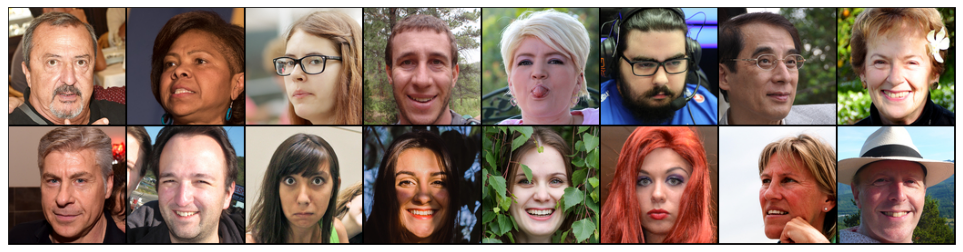

In [ ]:
show_batch(train_dl)

Напишем функцию, которая переносит даталоадер на выбранный девайс.

In [ ]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

И перенесем наш даталоадер на cuda.

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)

## Часть 2. Построение и обучение модели

Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

In [ ]:
discriminator = nn.Sequential(
    # in: 3 x 128 x 128

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 64 x 64

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 32 x 32

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 16 x 16

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 8 x 8

    nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [ ]:
latent_size = 512 # choose latent size

generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 8 x 8
    
    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 16 x 16

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 32 x 32

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 64 x 64

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 128 x 128
)

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [ ]:
!nvidia-smi

Sun Jun 20 18:50:27 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P0    28W /  70W |   1066MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
lr = 0.0005
epoch = 150

model = {
    "discriminator": discriminator.to(device),
    "generator": generator.to(device)
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}

In [ ]:
from torchsummary import summary

Убедимся, что построенные модели работают корректно: на выходе генератора получается трехканальное изображение размером 128*128, на выходе вероятность размером 1.

In [ ]:
summary(model['generator'], input_size=(latent_size,1,1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]       4,194,304
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
         LeakyReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 512, 8, 8]       4,194,304
       BatchNorm2d-5            [-1, 512, 8, 8]           1,024
         LeakyReLU-6            [-1, 512, 8, 8]               0
   ConvTranspose2d-7          [-1, 256, 16, 16]       2,097,152
       BatchNorm2d-8          [-1, 256, 16, 16]             512
         LeakyReLU-9          [-1, 256, 16, 16]               0
  ConvTranspose2d-10          [-1, 128, 32, 32]         524,288
      BatchNorm2d-11          [-1, 128, 32, 32]             256
        LeakyReLU-12          [-1, 128, 32, 32]               0
  ConvTranspose2d-13           [-1, 64, 64, 64]         131,072
      BatchNorm2d-14           [-1, 64,

In [ ]:
summary(model['discriminator'], input_size=(3,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           3,072
       BatchNorm2d-2           [-1, 64, 64, 64]             128
         LeakyReLU-3           [-1, 64, 64, 64]               0
            Conv2d-4          [-1, 128, 32, 32]         131,072
       BatchNorm2d-5          [-1, 128, 32, 32]             256
         LeakyReLU-6          [-1, 128, 32, 32]               0
            Conv2d-7          [-1, 256, 16, 16]         524,288
       BatchNorm2d-8          [-1, 256, 16, 16]             512
         LeakyReLU-9          [-1, 256, 16, 16]               0
           Conv2d-10            [-1, 512, 8, 8]       2,097,152
      BatchNorm2d-11            [-1, 512, 8, 8]           1,024
        LeakyReLU-12            [-1, 512, 8, 8]               0
           Conv2d-13            [-1, 512, 4, 4]       4,194,304
      BatchNorm2d-14            [-1, 51

In [ ]:
from IPython.display import clear_output

Создадим 16 рандомных фиксированных векторов, которые будем выводить после каждой эпохи чтобы визуально оценивать качество генерации. 

In [ ]:
fixed_latent = torch.randn(16, latent_size, 1, 1, device=device)

In [ ]:
def fit(model, criterion, epochs, lr, start_idx=1):
    model["discriminator"].train()
    model["generator"].train()
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    optimizer = {
        "discriminator": torch.optim.Adam(model["discriminator"].parameters(), 
                                          lr=lr, betas=(0.5, 0.999)),
        "generator": torch.optim.Adam(model["generator"].parameters(),
                                      lr=lr, betas=(0.5, 0.999))
    }
    # Пробовала использовать шедуллер, но остановилась на варианте без него
    #scheduler_disc = torch.optim.lr_scheduler.StepLR(optimizer['discriminator'], step_size=50, gamma=0.8)
    #scheduler_gen = torch.optim.lr_scheduler.StepLR(optimizer['generator'], step_size=50, gamma=0.8)
    for epoch in range(epochs):
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            # Clear discriminator gradients
            optimizer["discriminator"].zero_grad()

            # Pass real images through discriminator
            real_preds = model["discriminator"](real_images)
            real_targets = torch.ones(real_images.size(0), 1, device=device)
            #print(real_preds.shape)
            #print(real_targets.shape)
            real_loss = criterion["discriminator"](real_preds, real_targets)
            cur_real_score = torch.mean(real_preds).item()
            
            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)

            # Pass fake images through discriminator
            fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
            fake_preds = model["discriminator"](fake_images)
            fake_loss = criterion["discriminator"](fake_preds, fake_targets)
            cur_fake_score = torch.mean(fake_preds).item()

            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)

            # Update discriminator weights
            loss_d = real_loss + fake_loss
            loss_d.backward()
            optimizer["discriminator"].step()
            loss_d_per_epoch.append(loss_d.item())


            # Train generator
            # Clear generator gradients
            optimizer["generator"].zero_grad()
            
            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)
            
            # Try to fool the discriminator
            preds = model["discriminator"](fake_images)
            targets = torch.ones(batch_size, 1, device=device)
            loss_g = criterion["generator"](preds, targets)
            
            # Update generator weights
            loss_g.backward()
            optimizer["generator"].step()
            loss_g_per_epoch.append(loss_g.item())

        #scheduler_disc.step()
        #scheduler_gen.step()

        # Record losses & scores
        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, 
            losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1]))
        
        # Отображение лиц
        clear_output(wait=True)
        plt.figure(figsize=(17, 5))
        show_images(model["generator"](fixed_latent).cpu())
        
        # Отображение графиков лоссов после каждой эпохи
        plt.figure(figsize=(16, 4))
        plt.plot(np.arange(epoch+1), losses_g, label='Generator')
        plt.plot(np.arange(epoch+1), losses_d, label='Discriminator')
        plt.xlim(0, epochs)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
        
        plt.figure(figsize=(16, 4))
        plt.plot(np.arange(epoch+1), real_scores, label='Real')
        plt.plot(np.arange(epoch+1), fake_scores, label='Fake')
        plt.xlim(0, epochs)
        plt.xlabel('Epoch')
        plt.ylabel('Score')
        plt.legend()
        plt.show()

    
    return losses_g, losses_d, real_scores, fake_scores

<Figure size 1224x360 with 0 Axes>

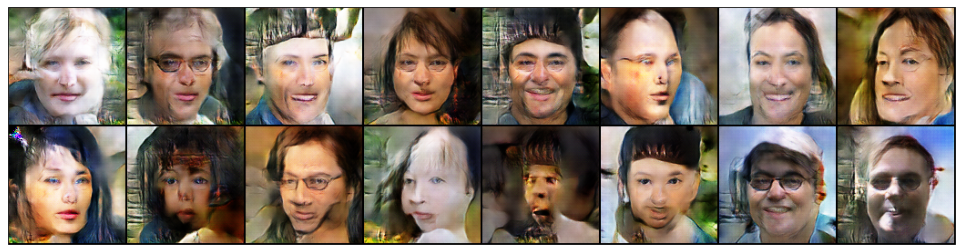

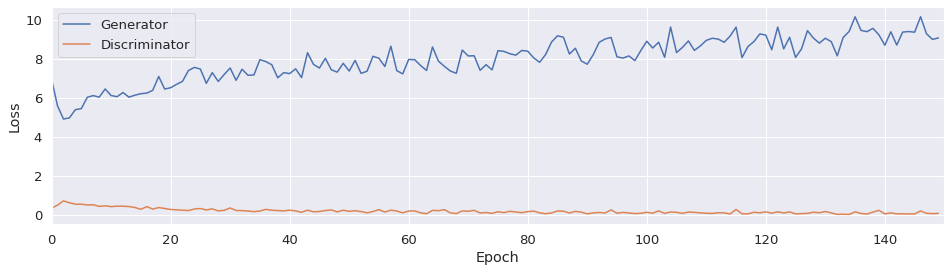

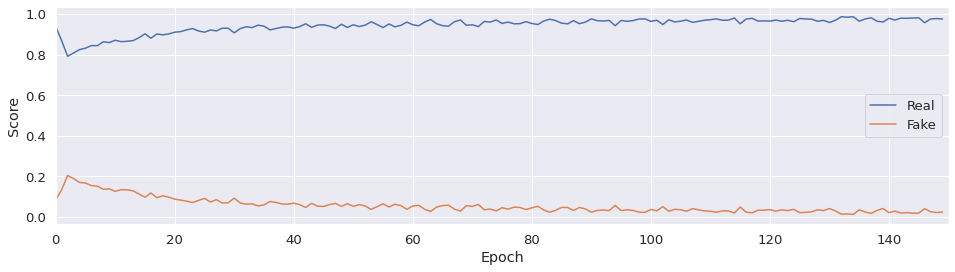

In [ ]:
history = fit(model, criterion, epoch, lr)

Лосс дискриминатора сначала низкий, потому что генератор генерирует просто шум, а затем он начинает расти, так как модель начинает учиться и в процессе обучения лосс дискриминатора снова уменьшается.

Лосс генератора наоборот, сначала уменьшается, а затем растет. В идеальном случае лоссы генератора и дискриминатора должны прийти в положение равновесия.

Однако, особенность таких моделей в том, что по графикам лоссов невозможно судить о качестве моделей.

Если говорить про скор дискриминатора, реальный скор стремится к единице, а фейковый скор стремится к нолю. Это говорит о том, что нам удается обмануть модель и она не видит сильной разницы между реальными изображениями и сгенерированными.

In [ ]:
path = '/content/drive/MyDrive/my_gan.pth'

Сохранение модели

In [ ]:
torch.save({
    'model_discriminator_state_dict': model['discriminator'].state_dict(),
    'model_generator_state_dict': model['generator'].state_dict()
}, path)

Загрузка модели

In [ ]:
checkpoint = torch.load(path)

model['discriminator'].load_state_dict(checkpoint['model_discriminator_state_dict'])
model['generator'].load_state_dict(checkpoint['model_generator_state_dict'])

<All keys matched successfully>

## Часть 3. Генерация изображений

Теперь давайте оценим качество получившихся изображений. Напишем функцию, которая выводит изображения, сгенерированные нашим генератором

In [ ]:
n_images = 5

fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)
fake_images = model["generator"](fixed_latent)

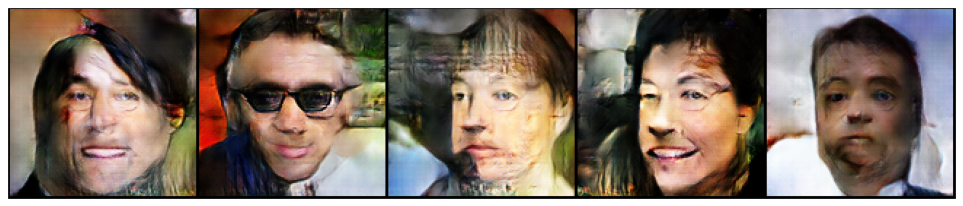

In [ ]:
show_images(fake_images.cpu())

Человеческим взглядодм можно определить, что это не настоящие изображения, однако модель хорошо сгенерировала овал лица, черты лица и в целом видно, что это люди.

## Часть 4. Leave-one-out-1-NN classifier accuracy

### 4.1. Подсчет accuracy

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

In [ ]:
torch.cuda.empty_cache()

In [ ]:
fixed_latent = torch.randn(3143, latent_size, 1, 1, device=device)


In [ ]:
fake_images = model["generator"](fixed_latent)

In [ ]:
fake_images = fake_images.detach().cpu()

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA

In [ ]:
knn = KNeighborsClassifier(n_neighbors=1)
loo = LeaveOneOut()
pca = PCA(n_components=100)

In [ ]:
batch_size = 3143

data = get_dataloader(image_size, batch_size, stats)
#data = DeviceDataLoader(data, device)

/content/faces_dataset_small_128/


In [ ]:
for real_images, _ in data:    
    all_img = torch.cat([real_images.reshape(3143,-1), fake_images.reshape(3143,-1)])

    real_targets = np.ones(real_images.size(0))
    fake_targets = np.zeros(fake_images.size(0))
    
    labels = np.concatenate((real_targets,fake_targets))#torch.cat([real_targets,fake_targets])

    labels_true = []
    labels_pred = []

    all_img = pca.fit_transform(all_img)
    

    for ind_train, ind_test in tqdm(loo.split(all_img, labels)):

        knn.fit(all_img[ind_train], labels[ind_train])
        pred = knn.predict(all_img[ind_test])
    
        labels_true.append(labels[ind_test])
        labels_pred.append(pred)

torch.Size([3143, 3, 128, 128])
torch.Size([6286, 49152])
(6286,)
(6286, 100)


In [ ]:
accuracy_score(labels_true, labels_pred)

0.842348075087496

Что вы можете сказать о получившемся результате? Какой accuracy мы хотели бы получить и почему?

В идеале, нам бы хотелось получить accuracy = 0.5, так как классификатор абсолютно не может отличить реальное изображение от фейкового.

У меня получилось accuracy = 0.84, то есть результат не идеальный (но оно и видно).

### 4.2. Визуализация распределений

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

In [ ]:
pca = PCA(n_components=2)

(6286, 49152)
(6286,)
(6286, 2)


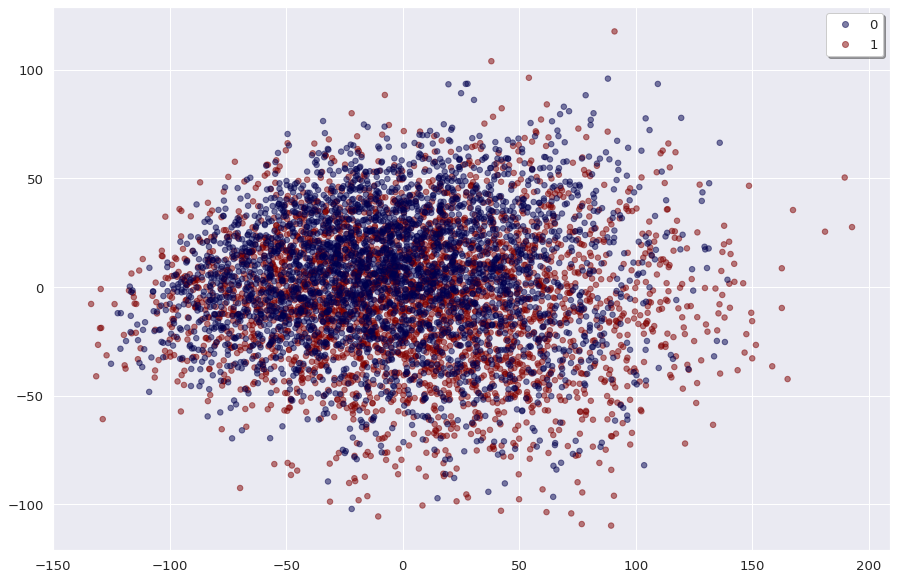

In [ ]:
for real_images, _ in data:    
    all_img = torch.cat([real_images.reshape(3143,-1),fake_images.reshape(3143,-1)])
    all_img = all_img.detach().cpu().numpy()
    print(all_img.shape)
    real_targets = np.ones(real_images.size(0))
    fake_targets = np.zeros(fake_images.size(0))
    
    labels = np.concatenate((real_targets,fake_targets))
    print(labels.shape)

    labels_true = []
    labels_pred = []

    img_pca = pca.fit_transform(all_img)
    print(img_pca.shape)

    plt.figure(figsize=(15, 10))
    fig = plt.scatter(img_pca[:, 0], img_pca[:, 1], c=labels, s=30, cmap='seismic', alpha=0.5)
    plt.legend(*fig.legend_elements(), shadow=True, facecolor='white')
    plt.show()
    

 В целом, нет четкого отделения облака точек сгенерированных изображений от реальных. Это хорошо.